In [1]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Specify working directory.
FOLDERNAME = 'cs231n/project/'
%cd /content/drive/My\ Drive/$FOLDERNAME

# Ensure that the Python interpreter of the Colab VM can load python files from
# within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive
/content/drive/My Drive/cs231n/project


## Retrieve hrnet feature maps

In [2]:
!unzip -o "dataset/hrnet_raw/*" -d "/content/hrnet"

Archive:  dataset/hrnet_raw/hrnet-20210510T182703Z-011.zip
  inflating: /content/hrnet/hrnet/S020_F_WAVE_WLK_FCE.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_STRE_STD_FCE.avi.npy  
  inflating: /content/hrnet/hrnet/S016_F_DRIN_WLK_RGT.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_SNEE_WLK_RGT_HF.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_CALL_WLK_RGT.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_COUG_STD_FCE.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_SNEE_WLK_RGT.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_SNEE_WLK_LFT_HF.avi.npy  
  inflating: /content/hrnet/hrnet/S013_F_WIPE_WLK_FCE_HF.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_CALL_WLK_LFT.avi.npy  
  inflating: /content/hrnet/hrnet/S011_F_SNEE_WLK_LFT.avi.npy  
  inflating: /content/hrnet/hrnet/S016_F_DRIN_WLK_FCE_HF.avi.npy  
  inflating: /content/hrnet/hrnet/S016_F_DRIN_WLK_FCE.avi.npy  
  inflating: /content/hrnet/hrnet/S013_F_WIPE_WLK_LFT_HF.avi.npy  
  inflating: /content/hrnet/hr

In [3]:
import os

hrnet_path = '/content/hrnet/hrnet'
len(os.listdir(hrnet_path))

1920

(61, 17, 64, 48)


<function matplotlib.pyplot.show>

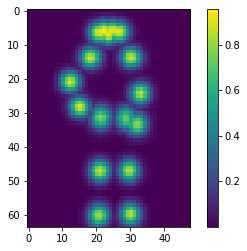

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sample = np.load(os.path.join(hrnet_path, 'S001_M_CALL_STD_FCE.avi.npy'))
print(sample.shape)

plt.imshow(np.max(sample[0,:,:,:], axis=0))
plt.colorbar()
plt.show

## Split Train/Val/Test datasets

In [5]:
import os
import pandas as pd

video_path = 'dataset/videos/'
videos = os.listdir(video_path)
subjects = []
actions =[]

for vid in videos:
  # Read index.
  subjects.append(vid[:4])
  # Read actions
  actions.append(vid.split('_')[2])

# Convert actions to 1 = flu sym, 0 = no flu sym.
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 0,
    'SCRA': 0,
    'SNEE': 1,
    'STRE': 0,
    'WAVE': 0,
    'WIPE': 0,
}
labels = [mapping[x] for x in actions]    

df_videos = pd.DataFrame({
    'video_subject': subjects,
    'video_name': videos,
    'action': actions,
    'label': labels
    
})
df_videos.head()

,video_subject,video_name,action,label
0,S019,S019_F_SCRA_STD_FCE_HF.avi,SCRA,0
1,S019,S019_F_WAVE_WLK_FCE_HF.avi,WAVE,0
2,S019,S019_F_COUG_WLK_FCE_HF.avi,COUG,1
3,S019,S019_F_WIPE_STD_RGT_HF.avi,WIPE,0
4,S019,S019_F_SCRA_STD_LFT_HF.avi,SCRA,0


In [6]:
# Shuffle df_videos.
df_videos = df_videos.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# From the paper authors: "In our current experiments, the videos from subjects
# S002, S003, S004, S005, S006 are used for testing and the rest are used for
# training."
df_videos_train = df_videos.loc[~df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
df_videos_test  = df_videos.loc[df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
print(df_videos_train.groupby('label').count())
print(df_videos_test.groupby('label').count())

       index  video_subject  video_name  action
label                                          
0       1080           1080        1080    1080
1        360            360         360     360
       index  video_subject  video_name  action
label                                          
0        360            360         360     360
1        120            120         120     120


In [8]:
train_ratio = 0.70

label_1_dat = df_videos_train.loc[df_videos_train["label"]==1,]
label_0_dat = df_videos_train.loc[df_videos_train["label"]==0,]

train_len_label1 = int(len(label_1_dat)*train_ratio)
train_len_label0 = int(len(label_0_dat)*train_ratio)

train_dat_label1 = label_1_dat.iloc[:train_len_label1,]
train_dat_label0 = label_0_dat.iloc[:train_len_label0,]

val_dat_label1 = label_1_dat.iloc[train_len_label1:,]
val_dat_label0 = label_0_dat.iloc[train_len_label0:,]

train_dat = train_dat_label1.append(train_dat_label0, ignore_index=True)
val_dat = val_dat_label1.append(val_dat_label0, ignore_index=True)

In [9]:
print(train_dat.groupby('action')['index'].count())
print(val_dat.groupby('action')['index'].count())

action
CALL    123
COUG    119
DRIN    133
SCRA    117
SNEE    132
STRE    127
WAVE    125
WIPE    131
Name: index, dtype: int64
action
CALL    57
COUG    61
DRIN    47
SCRA    63
SNEE    48
STRE    53
WAVE    55
WIPE    49
Name: index, dtype: int64


## Create input for model

Function below extracts the first x frames for each video and add paddings if videos are too short.

In [10]:
import os
import numpy as np

def create_hrnet_dataset(dataset, output_path):
    x = 60 # max timestep
    feature_channel, feature_row, feature_col = 17, 64, 48
    frames = []
    for i in np.arange(len(dataset)):
        if i % 10 == 0: print(f'Progress: {i} / {len(dataset)}')
        vid_name = dataset.video_name[i]
        feature_map = np.load(os.path.join(hrnet_path, vid_name+'.npy'))
        if len(feature_map) >= x:
            feature_map = feature_map[:x,:,:,:]
        else:
            # pre-padding: (x-len(feature_map),0)
            # post-padding: (0,x-len(feature_map)
            feature_map = np.pad(feature_map,
                                 ((x-len(feature_map),0),(0,0),(0,0),(0,0)),
                                 mode='constant',constant_values=-10)
        frames.append(feature_map)
    dataset_new = np.array(frames)
    dataset_new = dataset_new.reshape(
        (dataset_new.shape[0], x, feature_channel, feature_row, feature_col))
    labels = np.array(dataset.label)
    actions = np.array(dataset.action)
    return dataset_new, labels, actions

In [11]:
# Output directory.
output_path = "/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data/"

# Save final dataset.
try:
    os.mkdir(output_path)
except FileExistsError:
    pass

In [12]:
# Training dataset.
dataset_new, labels, actions = create_hrnet_dataset(train_dat, output_path)
print(dataset_new.shape)
np.save(os.path.join(output_path, "train_data_pre60"), dataset_new)
np.save(os.path.join(output_path, "train_labels_pre60"), labels)
np.save(os.path.join(output_path, "train_actions_pre60"), actions)

Progress: 0 / 1007
Progress: 10 / 1007
Progress: 20 / 1007
Progress: 30 / 1007
Progress: 40 / 1007
Progress: 50 / 1007
Progress: 60 / 1007
Progress: 70 / 1007
Progress: 80 / 1007
Progress: 90 / 1007
Progress: 100 / 1007
Progress: 110 / 1007
Progress: 120 / 1007
Progress: 130 / 1007
Progress: 140 / 1007
Progress: 150 / 1007
Progress: 160 / 1007
Progress: 170 / 1007
Progress: 180 / 1007
Progress: 190 / 1007
Progress: 200 / 1007
Progress: 210 / 1007
Progress: 220 / 1007
Progress: 230 / 1007
Progress: 240 / 1007
Progress: 250 / 1007
Progress: 260 / 1007
Progress: 270 / 1007
Progress: 280 / 1007
Progress: 290 / 1007
Progress: 300 / 1007
Progress: 310 / 1007
Progress: 320 / 1007
Progress: 330 / 1007
Progress: 340 / 1007
Progress: 350 / 1007
Progress: 360 / 1007
Progress: 370 / 1007
Progress: 380 / 1007
Progress: 390 / 1007
Progress: 400 / 1007
Progress: 410 / 1007
Progress: 420 / 1007
Progress: 430 / 1007
Progress: 440 / 1007
Progress: 450 / 1007
Progress: 460 / 1007
Progress: 470 / 1007
Pro

In [13]:
# Validation dataset.
dataset_new, labels, actions = create_hrnet_dataset(val_dat, output_path)
print(dataset_new.shape)
np.save(os.path.join(output_path, "val_data_pre60"), dataset_new)
np.save(os.path.join(output_path, "val_labels_pre60"), labels)
np.save(os.path.join(output_path, "val_actions_pre60"), actions)

Progress: 0 / 433
Progress: 10 / 433
Progress: 20 / 433
Progress: 30 / 433
Progress: 40 / 433
Progress: 50 / 433
Progress: 60 / 433
Progress: 70 / 433
Progress: 80 / 433
Progress: 90 / 433
Progress: 100 / 433
Progress: 110 / 433
Progress: 120 / 433
Progress: 130 / 433
Progress: 140 / 433
Progress: 150 / 433
Progress: 160 / 433
Progress: 170 / 433
Progress: 180 / 433
Progress: 190 / 433
Progress: 200 / 433
Progress: 210 / 433
Progress: 220 / 433
Progress: 230 / 433
Progress: 240 / 433
Progress: 250 / 433
Progress: 260 / 433
Progress: 270 / 433
Progress: 280 / 433
Progress: 290 / 433
Progress: 300 / 433
Progress: 310 / 433
Progress: 320 / 433
Progress: 330 / 433
Progress: 340 / 433
Progress: 350 / 433
Progress: 360 / 433
Progress: 370 / 433
Progress: 380 / 433
Progress: 390 / 433
Progress: 400 / 433
Progress: 410 / 433
Progress: 420 / 433
Progress: 430 / 433
(433, 60, 17, 64, 48)


In [14]:
# Test dataset.
dataset_new, labels, actions = create_hrnet_dataset(df_videos_test, output_path)
print(dataset_new.shape)
np.save(os.path.join(output_path, "test_data_pre60"), dataset_new)
np.save(os.path.join(output_path, "test_labels_pre60"), labels)
np.save(os.path.join(output_path, "test_actions_pre60"), actions)

Progress: 0 / 480
Progress: 10 / 480
Progress: 20 / 480
Progress: 30 / 480
Progress: 40 / 480
Progress: 50 / 480
Progress: 60 / 480
Progress: 70 / 480
Progress: 80 / 480
Progress: 90 / 480
Progress: 100 / 480
Progress: 110 / 480
Progress: 120 / 480
Progress: 130 / 480
Progress: 140 / 480
Progress: 150 / 480
Progress: 160 / 480
Progress: 170 / 480
Progress: 180 / 480
Progress: 190 / 480
Progress: 200 / 480
Progress: 210 / 480
Progress: 220 / 480
Progress: 230 / 480
Progress: 240 / 480
Progress: 250 / 480
Progress: 260 / 480
Progress: 270 / 480
Progress: 280 / 480
Progress: 290 / 480
Progress: 300 / 480
Progress: 310 / 480
Progress: 320 / 480
Progress: 330 / 480
Progress: 340 / 480
Progress: 350 / 480
Progress: 360 / 480
Progress: 370 / 480
Progress: 380 / 480
Progress: 390 / 480
Progress: 400 / 480
Progress: 410 / 480
Progress: 420 / 480
Progress: 430 / 480
Progress: 440 / 480
Progress: 450 / 480
Progress: 460 / 480
Progress: 470 / 480
(480, 60, 17, 64, 48)
